# Lancghain Based RAG Chatbot 

### Description :
This Jupyter Notebook demonstrates the implementation of a Retrieval Augmented Generation (RAG) chatbot using the LangChain framework. The chatbot is designed to answer questions based on the content of uploaded PDF documents. It leverages HuggingFace models for embeddings and language generation.

- Author : Kinsuk Ghatak
- Date Published : 8th June, 2025
- Github: https://github.com/kinsukghatak
- LinkedIn : https://www.linkedin.com/in/kinsukghatak/

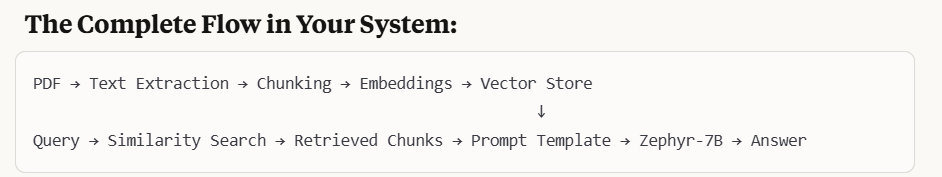

## Sec1 : Install Install necessary Python libraries and connect with HF API :

In [ ]:
# !pip install langchain-openai
# !pip install openai
# !pip install PyPDF2
# !pip install faiss-cpu
# !pip install tiktoken

# !pip install langchain-community
# pip install -U sentence-transformers --user
# pip install -U langchain-huggingface


# pip install --upgrade langchain langchain-huggingface huggingface-hub
# pip install urllib3==1.26.18

In [5]:
from PyPDF2 import PdfReader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
import os
from tkinter import Tk, filedialog
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFaceEndpoint
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.schema import Document


In [6]:
# First get the HuggingGace API toke and then Import the os module to interact with the operating system.
# The hugging face API is stored in a variable

os.environ["HUGGINGFACEHUB_API_TOKEN"] = "hf_XXXXXXXXXXXXXXXXXXXXXXX"

In [7]:
# --- Diagnostic Step ---
# This cell verifies if the Hugging Face API token is correctly loaded as an environment variable.
hf_token = os.environ.get("HUGGINGFACEHUB_API_TOKEN")
if hf_token:
    print("Hugging Face token found in environment.")
else:
    print("HUGGINGFACEHUB_API_TOKEN environment variable not found!")
    # Exit or handle the error appropriately
    exit()

Hugging Face token found in environment.


## Sec 2: Read & Process the PDF File, Extract content & Create Embeddings and Vector 
- Define a functions to open a file dialog and select a PDF file, load and read text content from the selected PDF
- Iterate through each page of the previously loaded PDF and store the content
- Split the extracted PDF text into manageable chunks by using CharacterTextSplitter to ensure the text chunks are within a suitable token size for language models
- Perform required embeddings of the text using HF model. Embeddings are numerical representations of text that capture semantic meaning
- Once Embeddings are done, create a FAISS vector store from the text chunks and their embeddings. Vector store allows for efficient similarity search, which is crucial for RAG.

In [8]:
import os
from PyPDF2 import PdfReader
from tkinter import Tk, filedialog

# Step 1: Open a file dialog to select PDF
def select_pdf():
    root = Tk()
    root.withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename(
        title="Select PDF File",
        filetypes=[("PDF files", "*.pdf")]
    )
    return file_path

# Step 2: Load and read the PDF
def read_pdf_text(file_path):
    reader = PdfReader(file_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() or ""
    return reader, text

# Step 3: Main execution
if __name__ == "__main__":
    pdf_path = select_pdf()
    if pdf_path:
        reader, pdf_text = read_pdf_text(pdf_path)
        
        file_name = os.path.basename(pdf_path)
        file_size_mb = round(os.path.getsize(pdf_path) / (1024 * 1024), 2)
        num_pages = len(reader.pages)
        
        print(f"\n📄 File Ingested: {file_name}")
        print(f"📚 Total Pages: {num_pages}")
        print(f"💾 File Size: {file_size_mb} MB")
        
        # You can continue processing with LangChain here
    else:
        print("No file selected.")



📄 File Ingested: Statistical_methods_in_credit_Risk_modelling.pdf
📚 Total Pages: 156
💾 File Size: 1.47 MB


In [10]:
from typing_extensions import Concatenate
# read text from pdf
raw_text = ''
for i, page in enumerate(reader.pages):
    content = page.extract_text()
    if content:
        raw_text += content

In [11]:
# We need to split the text using Character Text Split such that it sshould not increse token size
text_splitter = CharacterTextSplitter(
    separator = "\n",
    chunk_size = 800,
    chunk_overlap  = 200,
    length_function = len,
)
texts = text_splitter.split_text(raw_text)
texts = texts[:100]
print(f"🔤 Text chunks created: {len(texts)}")

🔤 Text chunks created: 100


In [12]:
# Download embeddings using Hugging Face model: 
# Step 3: Create embeddings and vector store
print("🔄 Creating embeddings...")
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


🔄 Creating embeddings...


In [13]:

# Create FAISS vector store
document_search = FAISS.from_texts(texts, embeddings)
print("✅ Vector store created successfully!")
document_search

✅ Vector store created successfully!


## Sec 4: LLM Intitialisation and Q&A with the PDF - The actual Chatbot creation :
- Initiate the LLM 
- Takes your question
- Quickly scans through your PDF document
- Finds the relevant sections
- Reads them and gives you a short, focused answer
- Only shows you the answer, not all the background work

### Details around the LLM Used : 
- Zephyr-7B-Beta is a conversational medium sized AI model with 7 billion parameters. 
- It is specifically designed for conversations and following instructions that's perfect for answering questions about documents in a natural, human-like way.
- It helps with fast responses through HuggingFace's cloud API and is free to use through HuggingFace API
- The model is good at question-answering, summarizing, and chat-like interactions

In [15]:

# Use a reliable text-generation model
llm = HuggingFaceEndpoint(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    huggingfacehub_api_token=os.environ["HUGGINGFACEHUB_API_TOKEN"],
    max_new_tokens=150,
    temperature=0.1,
    return_full_text=False
)

chain = load_qa_chain(llm, chain_type="stuff")
query = "what is this document all about?"
docs = document_search.similarity_search(query)

if docs:
    result = chain.invoke({"input_documents": docs, "question": query})
    answer = result['output_text'].strip()
    print("Answer:", answer)
#     print(result)
else:
    print("No documents found for the query")

Answer: This document is a thesis, and it is about developing a dual-time modeling framework based on observations on the vintage diagram, or "dual-time analytics". It discusses the vintage data structure, which appears in economic and financial data, as well as in clinical trials, demography, epidemiology, and dendrochronology. The thesis also mentions Moody's rating system and credit scoring in consumer lending. The main purpose of the thesis is to develop a dual-time modeling framework based on observations on the vintage diagram. The thesis acknowledges the guidance and support of several individuals, including professors and colleagues in the field of credit risk research. The thesis is dedicated to the author's parents in China
